In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

In [3]:
import sklearn
sklearn.__version__

'0.20.1'

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [4]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train_en'))
X_test, y_test = read_data(get_dataset('valid_en'))

2018-12-05 20:49:37,309 [INFO] Reading /opt/storage/english_train.csv..
2018-12-05 20:49:37,616 [INFO] Reading /opt/storage/english_valid.csv..


In [5]:
# del fm['tfidf_sv']
# del fm['tfidf_sv_dense']
# del fm['lsa_200_sv']
# del fm['lsa_500_sv']
# del fm['count_tiny']

In [6]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [7]:
from fgclassifier.features import FeaturePipeline, logger

def build_features(fm_names, fm):
    for name in fm_names:
        logger.info(f'Building features for {name}...')
        model = FeaturePipeline.from_spec(name, cache=fm)
        model.fit_transform(X_train)
        model.transform(X_test)
    
build_features(['count_en', 'count_en_sv'], fm)

2018-12-05 20:49:38,572 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-05 20:49:38,585 [INFO] Building features for count_en...
2018-12-05 20:50:05,052 [INFO] Vocab Size: 4000
2018-12-05 20:50:06,219 [INFO] Building features for count_en_sv...
2018-12-05 20:50:29,361 [INFO] Vocab Size: 2000


Exam the quality of the top terms:

In [8]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count_en', 'count_en_sv']:
    model = fm[mn]['model'].named_steps[mn]
    key = next(filter(lambda x: 'fit_transform' in x, fm[mn].keys()))
    x_train = fm[mn][key]
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.3f, max_df: %.3f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    if model.stop_words_:
        print('\nStop words size: %s\n' % len(model.stop_words_))
    
    # Remove stop words as they take a lot of memory
    model.stop_words_ = None
    
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:5]]))

Data Shape: (8000,) (2000,)

min_df: 3.000, max_df: 1.000, ngram_range: (1, 6)

vocab size: 4000


Stop words size: 3712557

good 	 18975
taste 	 13095
eat 	 11877
time 	 7277
delicious 	 7088

min_df: 3.000, max_df: 1.000, ngram_range: (1, 6)

vocab size: 2000


Stop words size: 3714557

good 	 18975
taste 	 13095
eat 	 11877
time 	 7277
delicious 	 7088


Save the word count features, as it is pretty slow to run for the whole dataset...

In [9]:
from sklearn.externals import joblib


def partial_get(d, keyword):
    key = next(filter(lambda x: x.startswith(keyword), d.keys()))
    return d[key]

def save_transform_cache(mn, path=None):
    path = path or f'data/fm_cache-{mn}'
    Xtrain = partial_get(fm[mn], 'fit_transform')
    Xtest = partial_get(fm[mn], 'transform')
    joblib.dump(Xtrain, path + '-train.pkl')
    joblib.dump(Xtest, path + '-test.pkl')
    print(f'Saved {path}')
    
save_transform_cache('count_en')
save_transform_cache('count_en_sv')
joblib.load('data/fm_cache-count-test.pkl')

Saved data/fm_cache-count_en
Saved data/fm_cache-count_en_sv


<2000x4000 sparse matrix of type '<class 'numpy.int64'>'
	with 280136 stored elements in Compressed Sparse Row format>

Build more features

In [20]:
build_features(['tfidf_en', 'tfidf_en_dense', 'lsa_500_en', 'lsa_1k_en'], fm)
build_features(['tfidf_en_sv', 'tfidf_en_sv_dense', 'lsa_500_en_sv', 'lsa_1k_en_sv'], fm)
# build_features(['tfidf_tiny', 'tfidf_tiny_dense', 'lsa_500_tiny'], fm)
build_features(['word2vec_en'], fm)

2018-12-05 21:11:08,921 [INFO] Building features for tfidf_en...
2018-12-05 21:11:08,922 [INFO]   tfidf_en: fit_transform use cache.
2018-12-05 21:11:08,923 [INFO]   tfidf_en: transform use cache.
2018-12-05 21:11:08,923 [INFO] Building features for tfidf_en_dense...
2018-12-05 21:11:08,924 [INFO]   tfidf_en_dense: fit_transform use cache.
2018-12-05 21:11:08,925 [INFO]   tfidf_en_dense: transform use cache.
2018-12-05 21:11:08,925 [INFO] Building features for lsa_500_en...
2018-12-05 21:11:08,926 [INFO]   lsa_500_en: fit_transform use cache.
2018-12-05 21:11:08,927 [INFO]   lsa_500_en: transform use cache.
2018-12-05 21:11:08,928 [INFO] Building features for lsa_1k_en...
2018-12-05 21:11:08,928 [INFO]   lsa_1k_en: fit_transform use cache.
2018-12-05 21:11:08,929 [INFO]   lsa_1k_en: transform use cache.
2018-12-05 21:11:08,931 [INFO] Building features for tfidf_en_sv...
2018-12-05 21:11:08,935 [INFO]   tfidf_en_sv: fit_transform use cache.
2018-12-05 21:11:08,942 [INFO]   tfidf_en_sv: 

In [21]:
save_transform_cache('tfidf_en')
save_transform_cache('lsa_500_en')
save_transform_cache('lsa_1k_en')

save_transform_cache('tfidf_en_sv')
save_transform_cache('lsa_500_en_sv')
save_transform_cache('lsa_1k_en_sv')

# save_transform_cache('tfidf_tiny')
# save_transform_cache('lsa_500_tiny')
# save_transform_cache('lsa_1k_tiny')

save_transform_cache('word2vec_en')

Saved data/fm_cache-tfidf_en
Saved data/fm_cache-lsa_500_en
Saved data/fm_cache-lsa_1k_en
Saved data/fm_cache-tfidf_en_sv
Saved data/fm_cache-lsa_500_en_sv
Saved data/fm_cache-lsa_1k_en_sv
Saved data/fm_cache-word2vec_en


## The Very Basic TF-IDF + LDA classifier

In [23]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.train import fm_cross_check

Check a basic model

In [24]:
model = Baseline('SGD_Logistic', fm=fm['lsa_1k_en']['model'])
# Always pass in the original features
# the pipeline will take care of the cache
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 21:11:37,288 [INFO]   lsa_1k_en: fit_transform use cache.
2018-12-05 21:11:47,336 [INFO]   lsa_1k_en: transform use cache.
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-05 21:11:47,449 [INFO]  F1 Score: 0.4400537993260894


lsa_1k_en_SGD_Logistic final score: 0.4400537993260894


Logistic is much slower but performs not much better than Stochastic logistic.

In [25]:
model = Baseline('SGD_Huber', fm=fm['lsa_1k_en']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 21:11:47,504 [INFO]   lsa_1k_en: fit_transform use cache.
2018-12-05 21:11:56,691 [INFO]   lsa_1k_en: transform use cache.
2018-12-05 21:11:56,836 [INFO]  F1 Score: 0.41832082945849275


lsa_1k_en_SGD_Huber final score: 0.41832082945849275


In [26]:
model = Baseline('SGD_SVC', fm=fm['lsa_1k_en']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 21:11:56,905 [INFO]   lsa_1k_en: fit_transform use cache.
2018-12-05 21:12:05,392 [INFO]   lsa_1k_en: transform use cache.
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-05 21:12:05,499 [INFO]  F1 Score: 0.44261309492249856


lsa_1k_en_SGD_SVC final score: 0.44261309492249856


In [27]:
# model = Baseline('Ridge', fm=fm['lsa_1k']['model'])
# model.fit(X_train, y_train)
# print(f'{model.name} final score:', model.score(X_test, y_test))

## Search for the Best Feature + Classifier Combination

In [28]:
# Run for all classifiers and feature builders
train_avg_scores, train_scores = defaultdict(dict), defaultdict(dict)
test_avg_scores, test_scores = defaultdict(dict), defaultdict(dict)
test_time, train_time = defaultdict(dict), defaultdict(dict)

In [29]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [30]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'test': test_scores,
        'test_time': test_time,
        'test_avg': test_avg_scores,
        'train': train_scores,
        'train_time': train_time,
        'train_avg': train_avg_scores
    }
}

In [32]:
from IPython.display import clear_output

# # We'd only need to run the dummy models on one feature model,
# # as they do not care about the features
fm_cross_check(
    ['count_en', 'count_en_sv',
     'tfidf_en', 'tfidf_en_sv'],
    ['DummyStratified', 'DummyMostFrequent'],
    model_cls=Dummy, **conf)

# # Naive Bayes models cannot handle negative values, so we pass
# # in only tfidf features
fm_cross_check(
    ['count_en', 'count_en_sv',
     'tfidf_en', 'tfidf_en_sv'],
    ['ComplementNB'], **conf)
clear_output()

In [33]:
# Only SGD methods can handle sparse matrix
fm_cross_check(
    [
     'tfidf_en', 'lsa_500_en', 'lsa_1k_en',
     'tfidf_en_sv', 'lsa_500_en_sv', 'lsa_1k_en_sv',
     'count_en', 'count_en_sv',
    ],
    ['SGD_Logistic', 'SGD_SVC'], **conf)

clear_output()

In [34]:
# All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_500_en', 'lsa_1k_en',
     'lsa_500_en_sv', 'lsa_1k_en_sv'],
    ['LDA', 'Ridge'], **conf)

clear_output()

In [35]:
results = fm_cross_check(
    ['word2vec_en'],
    ['SGD_Logistic', 'SGD_SVC', 'LDA', 'Ridge'], **conf)

2018-12-05 21:20:02,487 [INFO] 
2018-12-05 21:20:02,488 [INFO] ============ Feature Model: word2vec_en ============
2018-12-05 21:20:02,489 [INFO] 
2018-12-05 21:20:02,489 [INFO] Train for word2vec_en -> SGD_Logistic...
2018-12-05 21:20:02,490 [INFO]   word2vec_en: fit_transform use cache.
2018-12-05 21:20:40,366 [INFO]   word2vec_en: transform use cache.
2018-12-05 21:20:40,414 [INFO] -------------------------------------------------------
2018-12-05 21:20:40,414 [INFO] 【word2vec_en -> SGD_Logistic】 Train: 0.3425, Test: 0.3176
2018-12-05 21:20:40,415 [INFO] -------------------------------------------------------
2018-12-05 21:20:40,415 [INFO] Train for word2vec_en -> SGD_SVC...
2018-12-05 21:20:40,416 [INFO]   word2vec_en: fit_transform use cache.
2018-12-05 21:20:44,228 [INFO]   word2vec_en: transform use cache.
2018-12-05 21:20:44,458 [INFO]   word2vec_en: transform use cache.
2018-12-05 21:20:44,500 [INFO] -------------------------------------------------------
2018-12-05 21:20:44,

In [45]:
# results = fm_cross_check(
#     ['tfidf_en_sv_dense'],
#     ['LDA', 'Ridge'], **conf)

In [44]:
# This is very slow ...
# results = fm_cross_check(
#     ['tfidf_en_dense'],
#     ['LDA', 'Ridge'], **conf)

In [ ]:
# Boosting is too damn slow...
# results = fm_cross_check(
#     ['lsa_500',
#      'lsa_500_sv',
#      'lsa_500_tiny',
#      'lsa_1k',
#      'word2vec',
#     ],
#     ['XGB', 'AdaBoost', 'GradientBoost'], **conf)
# clear_output()

In [46]:
def merge_dense(obj):
    obj = obj.copy()
    obj['tfidf_en'] = {
        **obj['tfidf_en_dense'],
        **obj['tfidf_en']
    }
    obj['tfidf_en_sv'] = {
        **obj['tfidf_en_sv_dense'],
        **obj['tfidf_en_sv']
    }
    del obj['tfidf_en_dense']
    del obj['tfidf_en_sv_dense']
    return obj

def extract_scores(scores, avg_scores):
    scores = merge_dense(scores)
    avg_scores = merge_dense(avg_scores)
    rows = {}
    for fm_name in scores:
        for clf_name in avg_scores[fm_name]:
            key = f'{fm_name}.{clf_name}'
            rows[key] = [avg_scores[fm_name][clf_name], *scores[fm_name][clf_name]]
    df = pd.DataFrame(rows)
    df.index = ['average', *y_train.columns]
    return df.T.sort_values('average', ascending=False)

df_train = extract_scores(train_scores, train_avg_scores)
df_test = extract_scores(test_scores, test_avg_scores)
df_test

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
tfidf_en.SGD_SVC,0.467583,0.487217,0.393799,0.419891,0.397472,0.583570,0.456500,0.526544,0.548128,0.436352,...,0.473304,0.559240,0.503530,0.502140,0.393080,0.524899,0.358189,0.386113,0.470841,0.417374
tfidf_en.SGD_Logistic,0.464256,0.442452,0.379007,0.406745,0.412387,0.603273,0.477511,0.502309,0.545054,0.431994,...,0.495887,0.520538,0.489674,0.491728,0.404421,0.543234,0.359058,0.371863,0.482011,0.417517
tfidf_en_sv.SGD_Logistic,0.464071,0.472921,0.386665,0.404823,0.409243,0.591739,0.466789,0.501534,0.552484,0.474944,...,0.475429,0.512983,0.482956,0.494443,0.410051,0.528900,0.352357,0.373125,0.484783,0.414199
tfidf_en_sv.SGD_SVC,0.457374,0.476096,0.375236,0.412742,0.405710,0.575493,0.514029,0.486008,0.533903,0.456422,...,0.472362,0.513528,0.471989,0.484482,0.392412,0.485455,0.343075,0.405319,0.439222,0.403945
lsa_1k_en.LDA,0.454368,0.445317,0.358812,0.388751,0.418345,0.581160,0.505243,0.504937,0.550644,0.427758,...,0.484267,0.543256,0.468934,0.485295,0.384697,0.494390,0.321545,0.345267,0.454620,0.421553
lsa_1k_en_sv.LDA,0.452484,0.445352,0.355922,0.399219,0.418265,0.562532,0.522243,0.493508,0.549688,0.472555,...,0.469219,0.532102,0.462860,0.464698,0.375975,0.478603,0.322306,0.356342,0.462125,0.409056
lsa_1k_en.SGD_Logistic,0.450180,0.450662,0.371928,0.388396,0.397944,0.577695,0.485378,0.499907,0.535528,0.459091,...,0.479814,0.506372,0.456896,0.481939,0.378356,0.544161,0.350492,0.348162,0.484506,0.331364
tfidf_en_sv.LDA,0.448312,0.506257,0.383791,0.374519,0.405161,0.535522,0.534971,0.513691,0.515250,0.431571,...,0.456647,0.532774,0.500134,0.463873,0.371627,0.466809,0.322058,0.363210,0.429919,0.379037
lsa_1k_en.SGD_SVC,0.447716,0.457773,0.335850,0.412332,0.384964,0.564086,0.535782,0.509240,0.552019,0.375734,...,0.464065,0.465253,0.435426,0.471950,0.397454,0.519878,0.329763,0.358606,0.475240,0.400537
lsa_500_en.LDA,0.447672,0.466601,0.377816,0.392857,0.399718,0.591243,0.522958,0.497476,0.516120,0.451861,...,0.461023,0.494195,0.425627,0.456896,0.384755,0.508953,0.296754,0.335392,0.467483,0.408859


In [47]:
# Save the results
results = conf['results'].copy()
del results['models']  # don't save models (which are huuuuge)
joblib.dump(results, 'data/model-selection-en.pkl')

['data/model-selection-en.pkl']

In [48]:
# important columns
imp_cols = [
    'count_en', 'count_en_sv',
    'tfidf_en', 'tfidf_en_sv',
    'lsa_500_en', 'lsa_500_en_sv',
    'lsa_1k_en', 'lsa_1k_en_sv',
    'word2vec_en']

def extract_avg_scores(scores):
    scores = merge_dense(scores)
    df = pd.DataFrame(scores)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=False)
    df = df.sort_values(by='avg', ascending=False)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]

df_train_avg = extract_avg_scores(train_avg_scores)
df_test_avg = extract_avg_scores(test_avg_scores)
df_test_avg

,count_en,count_en_sv,tfidf_en,tfidf_en_sv,lsa_500_en,lsa_500_en_sv,lsa_1k_en,lsa_1k_en_sv,word2vec_en
LDA,NaN,NaN,0.416738,0.448312,0.447672,0.441367,0.454368,0.452484,0.412645
SGD_Logistic,0.416910,0.403101,0.464256,0.464071,0.433957,0.434667,0.450180,0.442917,0.317601
SGD_SVC,0.412893,0.409520,0.467583,0.457374,0.420454,0.420367,0.447716,0.436995,0.340939
ComplementNB,0.402473,0.390820,0.401165,0.392350,NaN,NaN,NaN,NaN,NaN
Ridge,NaN,NaN,0.364632,0.357650,0.357658,0.359679,0.361774,0.359401,0.340497
DummyStratified,0.249326,0.251043,0.249473,0.250878,NaN,NaN,NaN,NaN,NaN
DummyMostFrequent,0.200268,0.200268,0.200268,0.200268,NaN,NaN,NaN,NaN,NaN


In [49]:
def extract_running_time(times):
    df = pd.DataFrame(times)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=True)
    df = df.sort_values(by='avg', ascending=True)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]
    
df_train_time = extract_running_time(train_time)
df_test_time = extract_running_time(test_time)
df_train_time

,count_en,count_en_sv,tfidf_en,tfidf_en_sv,lsa_500_en,lsa_500_en_sv,lsa_1k_en,lsa_1k_en_sv,word2vec_en
DummyMostFrequent,0.109803,0.106144,0.094585,0.111814,NaN,NaN,NaN,NaN,NaN
DummyStratified,0.130748,0.111136,0.118689,0.109045,NaN,NaN,NaN,NaN,NaN
ComplementNB,6.312464,6.376746,0.265413,0.258438,NaN,NaN,NaN,NaN,NaN
SGD_SVC,2.921370,2.611184,2.556214,2.514359,5.462332,5.365768,8.753393,8.994739,4.042606
SGD_Logistic,3.219725,2.782426,2.763330,2.634400,6.172009,7.006600,11.157123,11.755748,37.876484
Ridge,NaN,NaN,NaN,NaN,20.399692,19.025398,58.270482,55.044896,8.830818
LDA,NaN,NaN,NaN,NaN,20.715331,17.984899,57.535871,52.838226,10.153746


In [50]:
df_test_time

,count_en,count_en_sv,tfidf_en,tfidf_en_sv,lsa_500_en,lsa_500_en_sv,lsa_1k_en,lsa_1k_en_sv,word2vec_en
DummyStratified,0.045119,0.020084,0.021278,0.025151,NaN,NaN,NaN,NaN,NaN
DummyMostFrequent,0.018976,0.038505,0.031594,0.070810,NaN,NaN,NaN,NaN,NaN
ComplementNB,0.042912,0.073161,0.039225,0.034559,NaN,NaN,NaN,NaN,NaN
SGD_SVC,0.050861,0.042167,0.043360,0.033043,0.064473,0.056355,0.133713,0.124724,0.042294
SGD_Logistic,0.050401,0.045477,0.041856,0.043071,0.064890,0.134810,0.086746,0.100671,0.047805
Ridge,NaN,NaN,NaN,NaN,0.084594,0.066643,0.084061,0.083194,0.048391
LDA,NaN,NaN,NaN,NaN,0.113136,0.059238,0.100123,0.139906,0.044254


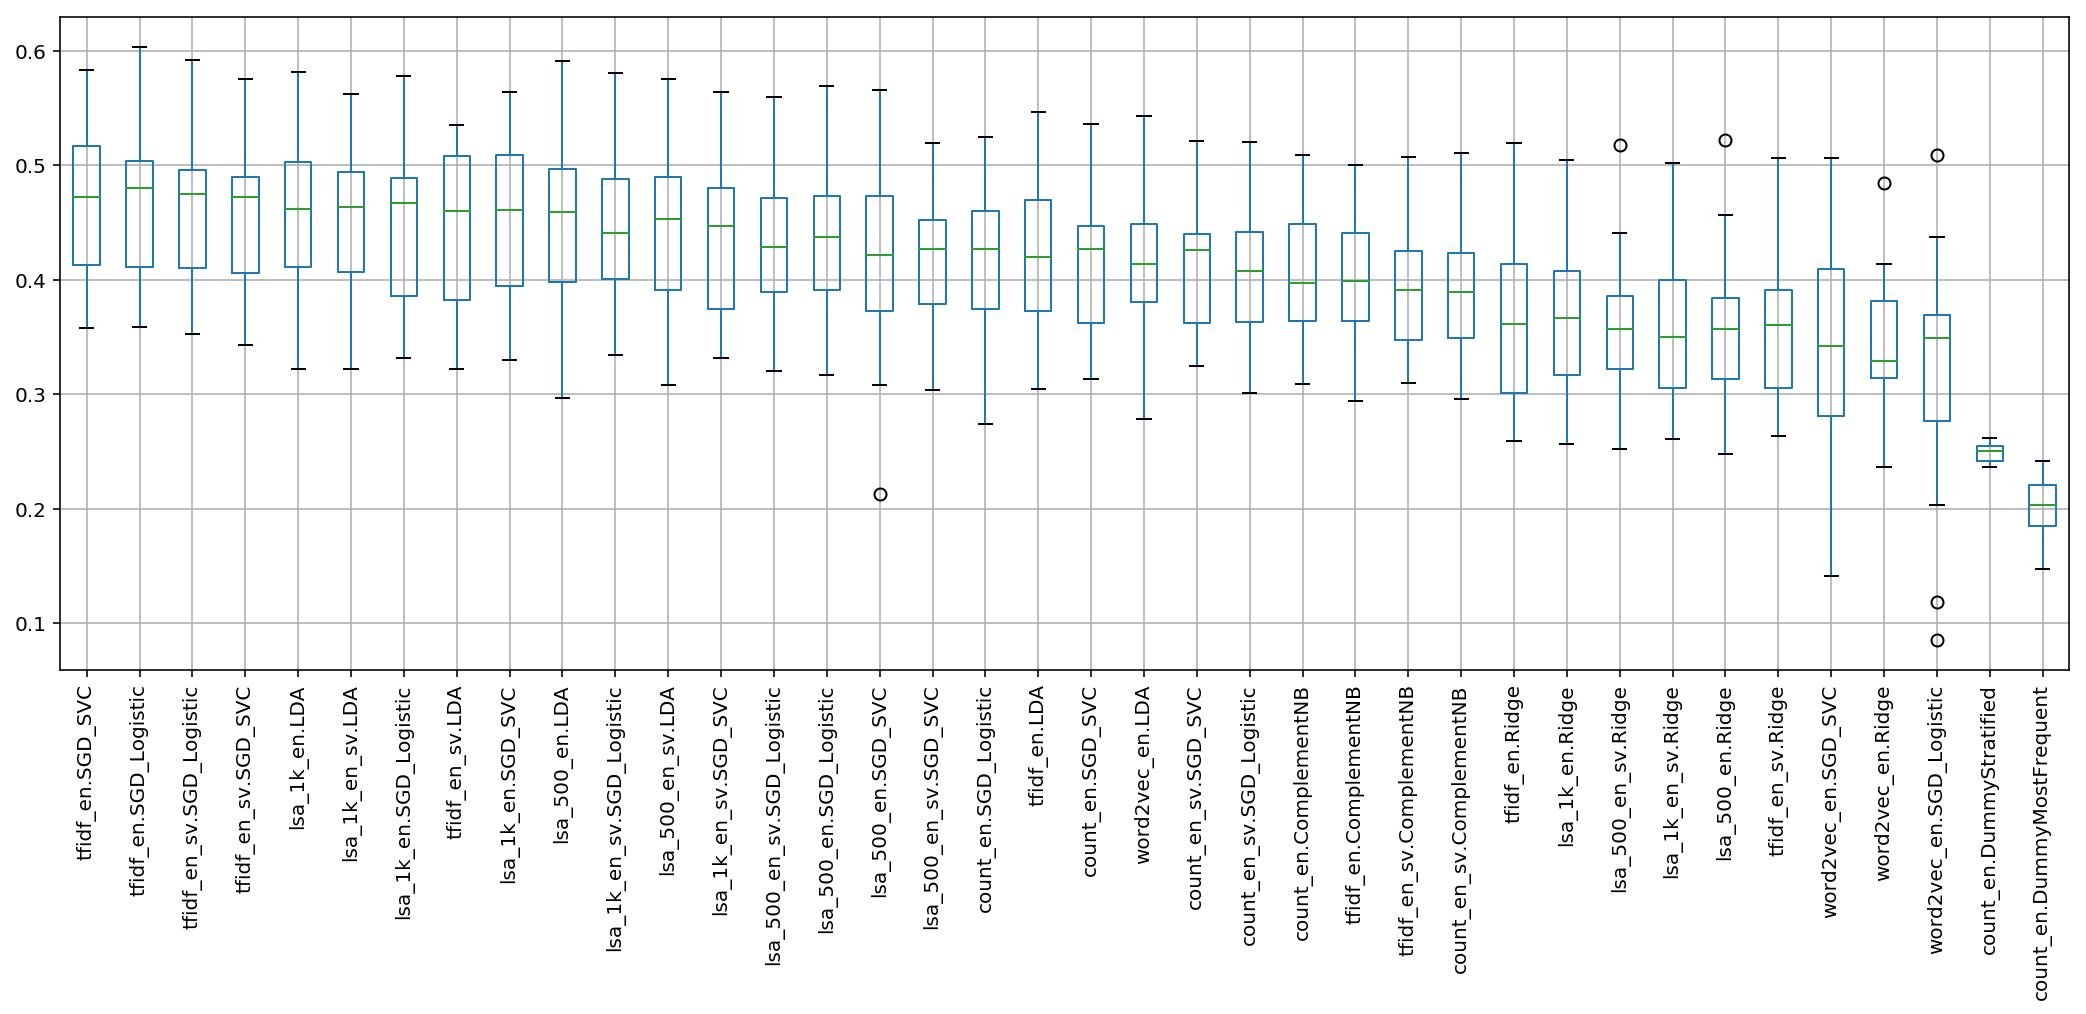

In [52]:
import matplotlib.pyplot as plt

df_test.drop([
    'tfidf_en.DummyStratified',
    'tfidf_en.DummyMostFrequent',
    'tfidf_en_sv.DummyStratified',
    'tfidf_en_sv.DummyMostFrequent',
    'count_en_sv.DummyStratified',
    'count_en_sv.DummyMostFrequent',
]).T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [53]:
results = conf['results']

In [54]:
from fgclassifier.utils import save_model

def clear_cache(model):
    if hasattr(model, 'steps'):
        for (name, step) in model.steps:
            clear_cache(step)
    if hasattr(model, 'cache'):
        model.cache = None
    return model

for name, model in results['models'].items():
    # skip unimportant models
    if 'QDA' in name:
        continue
    clear_cache(model)
    save_model(model)

clear_output()

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df, ngram range, max_features) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [ ]:
# model = results['models']['lsa_500_en_LDA']
# print(X_test[0:1].shape)
# probas = model.predict_proba(X_test[0:1])
# probas[0].shape

In [ ]:
# model.predict(X_test[0:1])